# PREPROCESS

In [ ]:
from PIL import Image
from glob import glob
from tqdm import tqdm
import os

from multiprocessing import Pool

In [ ]:
OUTPUT_SIZE = (512, 512)
OUTPUT_DIR = '../input/images_resize/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
pathes = glob(os.path.join('../input/jpeg/train/', '*.jpg'))

print(f'{len(pathes)} images found')

Get resolutions

In [ ]:
%%time
import numpy as np
import pandas as pd


def get_res(img_path: str):
    img = Image.open(img_path)
    return [img.height, img.width]

resolutions = list(map(get_res, pathes))

unique_resolutions = [list(x) for x in set(tuple(x) for x in resolutions)]
unique_resolutions

Process single image

In [ ]:
img = Image.open(pathes[0])
img.resize(OUTPUT_SIZE, Image.BICUBIC)

Process the whole dataset with progress bar

In [ ]:
%%time

def resize_img(img_path: str):
    img = Image.open(img_path)
    img = img.resize(OUTPUT_SIZE, Image.BICUBIC)
    img.save(os.path.join(OUTPUT_DIR, os.path.basename(img_path)))


with Pool(8) as p:
    list(tqdm(p.imap(resize_img, pathes), total=len(pathes)))

# CREATE FOLDS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [ ]:
FEATURES = 'image_name'
TARGET = 'target'

In [ ]:
df = pd.read_csv('../input/train.csv')
df['kfold'] = np.nan
# df = df.sample(frac=1).reset_index(drop=True)

X = df[FEATURES].values
y = df[TARGET].values

In [ ]:
valid=10
skf = StratifiedKFold(n_splits=int(100/valid), random_state=42)

for fold, (train, valid) in enumerate(skf.split(X, y)):
    if fold == 0:
        df.loc[valid, 'kfold'] = -1
    else:
        break

df_valid = df[df['kfold'] == -1].reset_index(drop=True)

In [ ]:
df_train = df[df['kfold'].isnull()].reset_index(drop=True)
X = df_train[FEATURES].values
y = df_train[TARGET].values

skf = StratifiedKFold(n_splits=5, random_state=42)
for fold, (train, valid) in enumerate(skf.split(X, y)):
    df_train.loc[valid, 'kfold'] = fold

df = pd.concat([df_train, df_valid])
df.reset_index(drop=True, inplace=True)
print('Number of samples per class:')
print(df['kfold'].value_counts(dropna=False))
print('\nClass "-1" is for validation')

# DATASET

In [2]:
%matplotlib inline

In [3]:
INPUT_DIR = '../input/'

In [4]:
from os.path import join
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
transforms_train = A.Compose([
    # Rigid aug
    A.OneOf([
        A.ShiftScaleRotate(rotate_limit=90, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.5),


    # Pixels aug
    A.OneOf([
        A.RandomBrightnessContrast(p=1.0),
        A.RandomGamma(p=1.0)
    ], p=0.5),


    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

In [108]:
class MelanomaDataset(Dataset):
    def __init__(self, df, input_dir, transforms=None):
        self.df = df
        self.input_dir = input_dir
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = join(self.input_dir, 'images_resized/', self.df.loc[idx, 'image_name'] + '.jpg')
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = np.transpose(image, (2, 0, 1))
        
        label = self.df.loc[idx, 'target'].astype(np.int8)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, label

In [79]:
train_df = pd.read_csv(join(INPUT_DIR, 'train.csv'))
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [80]:
submission_df = pd.read_csv(join(INPUT_DIR + 'sample_submission.csv'))
submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [95]:
BATCH_SIZE = 64

dataset_test = MelanomaDataset(submission_df, INPUT_DIR, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

dataset_train = MelanomaDataset(train_df, INPUT_DIR)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

0


TypeError: Invalid shape (3, 512, 512) for image data

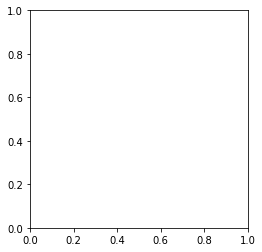

In [82]:
import matplotlib.pyplot as plt
print(dataset_train[25][1])
plt.imshow(dataset_train[25][0])

In [ ]:
plt.imshow(A.ShiftScaleRotate(rotate_limit=90, p=1)(image=dataset_train[25][0])['image'])

# Model

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.models as models

from efficientnet_pytorch import EfficientNet

import gc

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [98]:
# model = torchvision.models.resnet18(pretrained=True)
# model = EfficientNet.from_name('efficientnet-b5')
# num_ftrs = model._fc.in_features
# model._fc = nn.Linear(num_ftrs, 1)

In [107]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.max = nn.AdaptiveMaxPool2d(output_size=(1, 1))

    def forward(self, x):
        avg_x = self.avg(x)
        max_x = self.max(x)
        return torch.cat([avg_x, max_x], dim=1)


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)


class Model(nn.Module):
    
    def __init__(self, c_out=1):
        super().__init__()
        m = models.resnet34(pretrained=True)
            
        c_feature = list(m.children())[-1].in_features
        self.base = nn.Sequential(*list(m.children())[:-2])
        self.head = nn.Sequential(AdaptiveConcatPool2d(),
                                  Flatten(),
                                  nn.Linear(c_feature * 2, c_out))

        
    def forward(self, x):
        h = self.base(x)
        logits = self.head(h).squeeze(1)
        return logits

model = Model()
model.to(device);

In [100]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

criterion = {'focal': FocalLoss()}

In [101]:
BATCH_SIZE = 64
NUM_WORKERS = 8

submission_df = pd.read_csv(join(INPUT_DIR + 'sample_submission.csv'))
train_df = pd.read_csv(join(INPUT_DIR, 'train_folds.csv'))


dataset_train = MelanomaDataset(train_df[train_df['kfold'].isin([0,1,2,3])], INPUT_DIR)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

dataset_val = MelanomaDataset(train_df[train_df['kfold'].isin([4])], INPUT_DIR)
dataloader_val = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

loaders = {
    "train": dataloader_train,
    "valid": dataloader_val,
}

In [102]:
dataset_train

In [103]:
LR = 3e-4
EPOCHS = 30

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=3e-6)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10 * LR, 
                                                epochs=EPOCHS, steps_per_epoch=len(dataloader_train))

In [104]:
from catalyst.dl import SupervisedRunner

In [105]:
runner = SupervisedRunner()

In [106]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[dl.callbacks.metrics.auc.AUCCallback()],
    logdir="./logs",
    num_epochs=EPOCHS,
    main_metric='auc',
    verbose=True,
    fp16=False,
    timeit=True
)






1/30 * Epoch (train):   0% 0/373 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [109]:
torch.cuda.empty_cache()
gc.collect()

11105

In [ ]:
dataset_test = MelanomaDataset(submission_df, INPUT_DIR, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)